Initial shape: (96453, 12)


<ipython-input-6-5613c6615c51>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.columns] = imputer.fit_transform(df)


X_train shape: (71355, 6)
y_train shape: (71355,)


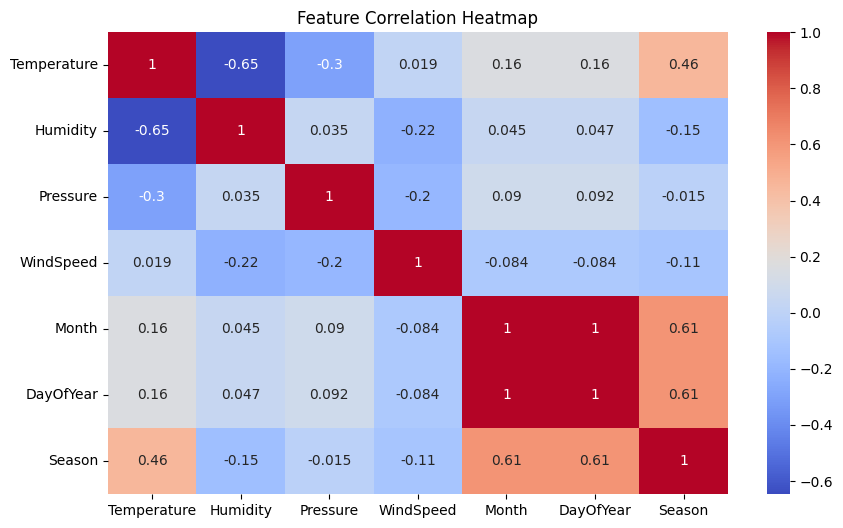

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv("weatherHistory.csv")
print("Initial shape:", df.shape)

# Rename columns for clarity
df.rename(columns={
    'Formatted Date': 'Date',
    'Temperature (C)': 'Temperature',
    'Humidity': 'Humidity',
    'Wind Speed (km/h)': 'WindSpeed',
    'Pressure (millibars)': 'Pressure'
}, inplace=True)

# Convert string date into datetime using datetime.strptime
def parse_date(date_str):
    try:
        return datetime.strptime(date_str[:19], "%Y-%m-%d %H:%M:%S")
    except:
        return np.nan

df['ParsedDate'] = df['Date'].apply(parse_date)

# Remove rows where date parsing failed
df = df.dropna(subset=['ParsedDate'])

# Extract time features manually
df['Month'] = df['ParsedDate'].apply(lambda x: x.month)
df['DayOfYear'] = df['ParsedDate'].apply(lambda x: x.timetuple().tm_yday)
df['Season'] = df['Month'].apply(lambda m: (m % 12) // 3 + 1)  # 1: Winter, 2: Spring, etc.

# Drop original date columns
df.drop(columns=['Date', 'ParsedDate'], inplace=True)

# Keep only the relevant features
df = df[['Temperature', 'Humidity', 'Pressure', 'WindSpeed', 'Month', 'DayOfYear', 'Season']]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
df[df.columns] = imputer.fit_transform(df)

# Remove outliers using IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df = remove_outliers(df, ['Temperature', 'Humidity', 'Pressure', 'WindSpeed'])

# Normalize features
features = ['Humidity', 'Pressure', 'WindSpeed', 'Month', 'DayOfYear', 'Season']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Split features and target
X = df.drop(columns=['Temperature'])
y = df['Temperature']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Final shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()



📊 Rebuilt Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.012
Root Mean Squared Error (RMSE): 1.510
R² Score: 0.975


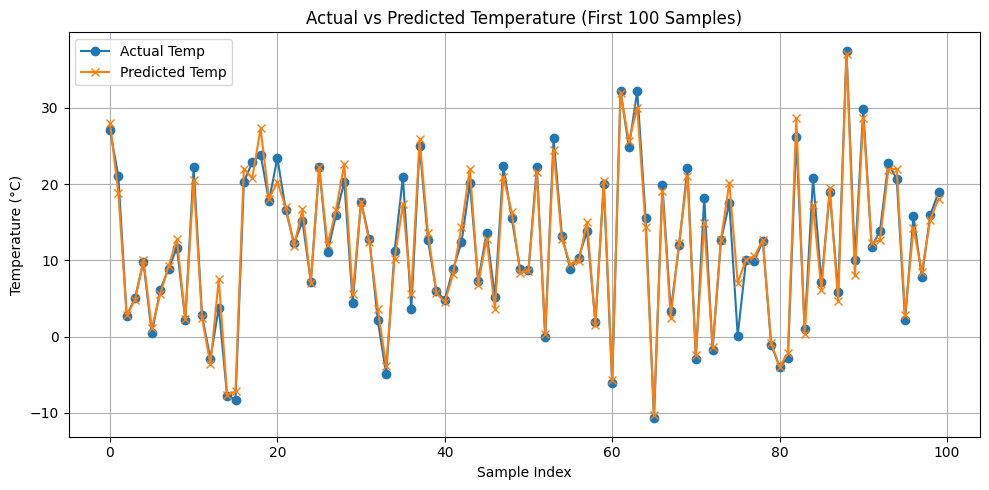

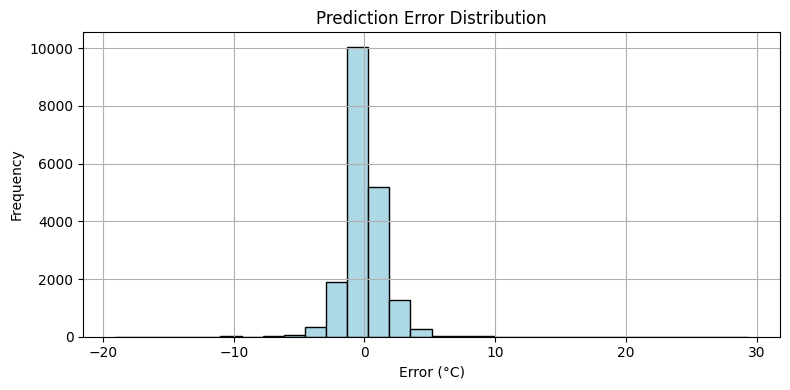

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 1: Load and preprocess the dataset ===
df = pd.read_csv("weatherHistory.csv")

# Rename relevant columns
df.rename(columns={
    'Formatted Date': 'Date',
    'Temperature (C)': 'Temperature',
    'Humidity': 'Humidity',
    'Wind Speed (km/h)': 'WindSpeed',
    'Pressure (millibars)': 'Pressure',
    'Summary': 'Summary'
}, inplace=True)

# Convert string to datetime manually
def parse_date(date_str):
    try:
        return datetime.strptime(date_str[:19], "%Y-%m-%d %H:%M:%S")
    except:
        return np.nan

df['ParsedDate'] = df['Date'].apply(parse_date)
df.dropna(subset=['ParsedDate'], inplace=True)

# Extract time-based features
df['Month'] = df['ParsedDate'].apply(lambda x: x.month)
df['DayOfYear'] = df['ParsedDate'].apply(lambda x: x.timetuple().tm_yday)
df['Season'] = df['Month'].apply(lambda m: (m % 12) // 3 + 1)

# Add lag and interaction features
df['Temp_lag1'] = df['Temperature'].shift(1)
df.dropna(inplace=True)

df['Humidity_Pressure'] = df['Humidity'] * df['Pressure']
df['Humidity_Wind'] = df['Humidity'] * df['WindSpeed']

# Final features and target
features = [
    'Humidity', 'Pressure', 'WindSpeed', 'Summary',
    'Month', 'DayOfYear', 'Season',
    'Temp_lag1', 'Humidity_Pressure', 'Humidity_Wind'
]
target = 'Temperature'

X = df[features]
y = df[target]

# Separate numerical and categorical
numeric_features = [
    'Humidity', 'Pressure', 'WindSpeed',
    'Month', 'DayOfYear', 'Season',
    'Temp_lag1', 'Humidity_Pressure', 'Humidity_Wind'
]
categorical_features = ['Summary']

# Preprocessing transformers
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Final pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# === Evaluation ===
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Rebuilt Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

# === Visualization 1: Actual vs Predicted ===
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label="Actual Temp", marker='o')
plt.plot(y_pred[:100], label="Predicted Temp", marker='x')
plt.title("Actual vs Predicted Temperature (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Visualization 2: Prediction Error Distribution ===
errors = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=30, color='lightblue', edgecolor='black')
plt.title("Prediction Error Distribution")
plt.xlabel("Error (°C)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import datetime

# STEP 1: Define your future input
# You can change these values based on a weather forecast or simulation
future_input = {
    'Humidity': 0.60,              # Example: 60% humidity
    'Pressure': 1010.5,            # Pressure in millibars
    'WindSpeed': 5.8,              # Wind speed in km/h
    'Month': 6,                    # June
    'DayOfYear': 170,             # June 18 (example)
    'Season': 2,                   # Spring
    'Temp_lag1': 22.3,             # Yesterday's temp (approx)
    'Humidity_Pressure': 0.60 * 1010.5,
    'Humidity_Wind': 0.60 * 5.8,
    'Summary': 'Partly Cloudy'     # One of the values from original dataset
}

# STEP 2: Convert to DataFrame
future_df = pd.DataFrame([future_input])

# STEP 3: Predict using the trained pipeline
predicted_temp = pipeline.predict(future_df)[0]

# STEP 4: Display result
print(f"🌡️ Predicted Temperature: {predicted_temp:.2f}°C")


🌡️ Predicted Temperature: 21.96°C
